In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

In [2]:
combine_dir = Path("../results/combine")
ablation_dir = Path("../results/ablation_results")

all_results_path = combine_dir / "all_results.csv"
mitigation_path = combine_dir / "mitigation_preview.csv"
ablation_path = ablation_dir / "ablation_results.csv"

all_df = pd.read_csv(all_results_path)
mit_df = pd.read_csv(mitigation_path)
abl_df = pd.read_csv(ablation_path)

print("✅ Loaded datasets:")
print(f"All Results: {all_df.shape}")
print(f"Mitigation: {mit_df.shape}")
print(f"Ablation: {abl_df.shape}")

✅ Loaded datasets:
All Results: (117, 6)
Mitigation: (32, 6)
Ablation: (75, 6)


In [4]:
# Cell 3 — Clean Columns and Combine (final robust version)
import pandas as pd

def clean_cols(df):
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    if "unnamed:_0" in df.columns:
        df = df.drop(columns=["unnamed:_0"])
    return df

# Load Data
all_df = pd.read_csv("../results/combine/all_results.csv")
mit_df = pd.read_csv("../results/combine/mitigation_preview.csv")
abl_df = pd.read_csv("../results/ablation_results/ablation_results.csv")

# Clean column names
all_df = clean_cols(all_df)
mit_df = clean_cols(mit_df)
abl_df = clean_cols(abl_df)

# Ensure consistent column naming
if "file" in mit_df.columns:
    mit_df = mit_df.rename(columns={"file": "scenario"})
if "scenario" not in mit_df.columns:
    mit_df["scenario"] = "unknown_mitigation"

# If any dataset lacks 'type', add a placeholder
for df, name in zip([all_df, mit_df, abl_df], ["All", "Mitigation", "Ablation"]):
    if "type" not in df.columns:
        df["type"] = "macro avg"
        print(f"⚠ Added missing 'type' column to {name} dataset")

# Combine all
combined = pd.concat([all_df, mit_df, abl_df], ignore_index=True)

# Clean scenario names
combined["scenario"] = combined["scenario"].astype(str).str.replace(".csv", "", regex=False)

# Normalize 'type' values for filtering
combined["type"] = combined["type"].astype(str).str.capitalize()

# Show summary
print(f"🔹 Combined shape: {combined.shape}")
print(f"🔹 Columns: {list(combined.columns)}")
print(f"🔹 Scenarios: {combined['scenario'].nunique()}")
print(f"🔹 Type values: {combined['type'].unique()}")

combined.head()

⚠ Added missing 'type' column to All dataset
⚠ Added missing 'type' column to Mitigation dataset
⚠ Added missing 'type' column to Ablation dataset
🔹 Combined shape: (224, 6)
🔹 Columns: ['precision', 'recall', 'f1-score', 'support', 'scenario', 'type']
🔹 Scenarios: 15
🔹 Type values: ['Macro avg']


,precision,recall,f1-score,support,scenario,type
0,0.996037,0.999510,0.997770,83726.0,baseline,Macro avg
1,0.000000,0.000000,0.000000,74.0,baseline,Macro avg
2,0.999797,0.998783,0.999290,4932.0,baseline,Macro avg
3,0.997222,0.899749,0.945982,399.0,baseline,Macro avg
4,0.999537,0.985679,0.992560,6564.0,baseline,Macro avg


In [5]:
summary = (
    combined.groupby(["scenario", "type"])[["precision", "recall", "f1-score"]]
    .mean()
    .reset_index()
)
summary = summary.sort_values("f1-score", ascending=False)
summary.head(10)

,scenario,type,precision,recall,f1-score
10,no_Flow,Macro avg,0.915846,0.885403,0.899053
11,no_Idle,Macro avg,0.913060,0.872111,0.889866
0,all_features,Macro avg,0.914054,0.870026,0.888906
12,no_Packet,Macro avg,0.914054,0.870026,0.888906
9,no_Flag,Macro avg,0.912223,0.871629,0.888813
7,bias_region_eu_bias,Macro avg,0.905302,0.850147,0.867827
3,bias_gender_male_bias,Macro avg,0.889005,0.848752,0.860118
13,smote_model,Macro avg,0.857498,0.851869,0.850807
6,bias_region_asia_bias,Macro avg,0.877331,0.813219,0.826398
14,weighted_model,Macro avg,0.825925,0.806673,0.813798


In [25]:
# 🧱 Identify scenario groups
import re

metrics_df["group"] = metrics_df["scenario"].apply(
    lambda x: "baseline" if "baseline" in x
    else "bias" if "bias" in x
    else "mitigation" if re.search("smote|weighted", x)
    else "ablation"
)

print(metrics_df["group"].value_counts())


group
bias          101
ablation       75
mitigation     32
baseline       16
Name: count, dtype: int64


C:\Users\bhand\AppData\Local\Temp\ipykernel_6556\4116959062.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_f1, x="group", y="f1-score", palette="viridis")


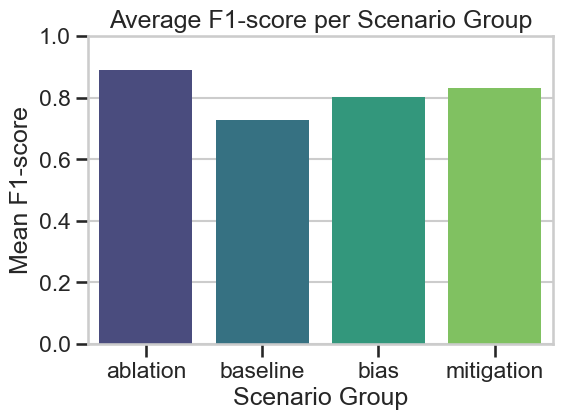

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

group_f1 = metrics_df.groupby("group")["f1-score"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=group_f1, x="group", y="f1-score", palette="viridis")
plt.title("Average F1-score per Scenario Group")
plt.ylabel("Mean F1-score")
plt.xlabel("Scenario Group")
plt.ylim(0,1)
plt.show()


C:\Users\bhand\AppData\Local\Temp\ipykernel_6556\2514622536.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metrics_df, x="group", y="delta_vs_baseline", palette="coolwarm")


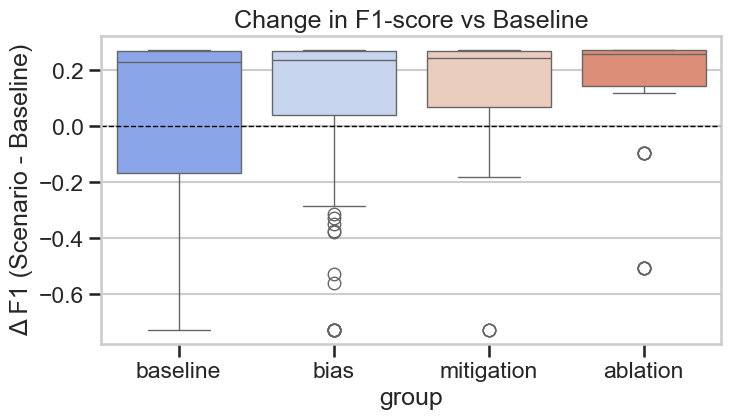

In [27]:
baseline_mean = metrics_df.query("group == 'baseline'")["f1-score"].mean()
metrics_df["delta_vs_baseline"] = metrics_df["f1-score"] - baseline_mean

plt.figure(figsize=(8,4))
sns.boxplot(data=metrics_df, x="group", y="delta_vs_baseline", palette="coolwarm")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Change in F1-score vs Baseline")
plt.ylabel("Δ F1 (Scenario - Baseline)")
plt.show()


In [20]:
# 🔹 Load and combine all three result sources

import pandas as pd

# Paths (adjust if needed)
all_path = "../results/combine/all_results.csv"
mitigation_path = "../results/combine/mitigation_preview.csv"
ablation_path = "../results/ablation_results/ablation_results.csv"

# Read CSVs
all_df = pd.read_csv(all_path)
mit_df = pd.read_csv(mitigation_path)
abl_df = pd.read_csv(ablation_path)

# Normalize column names
for df in [all_df, mit_df, abl_df]:
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Standardize key column names
mit_df = mit_df.rename(columns={"file": "scenario"})
abl_df = abl_df.rename(columns={"scenario": "scenario"})

# Add a dataset origin tag (optional)
all_df["origin"] = "all_results"
mit_df["origin"] = "mitigation"
abl_df["origin"] = "ablation"

# Combine everything
metrics_df = pd.concat([all_df, mit_df, abl_df], ignore_index=True)

# Clean text
metrics_df["scenario"] = metrics_df["scenario"].astype(str).str.strip().str.lower()

print("✅ Combined DataFrame shape:", metrics_df.shape)
print(metrics_df.head())
print("\n🔹 Unique scenarios:", metrics_df["scenario"].unique())


✅ Combined DataFrame shape: (224, 7)
  unnamed:_0  precision    recall  f1-score  support  scenario       origin
0          0   0.996037  0.999510  0.997770  83726.0  baseline  all_results
1          1   0.000000  0.000000  0.000000     74.0  baseline  all_results
2          2   0.999797  0.998783  0.999290   4932.0  baseline  all_results
3          3   0.997222  0.899749  0.945982    399.0  baseline  all_results
4          4   0.999537  0.985679  0.992560   6564.0  baseline  all_results

🔹 Unique scenarios: ['baseline' 'bias_gender_female_bias' 'bias_gender_male_bias'
 'bias_label_imbalance_class0' 'bias_label_noise_5pct'
 'bias_region_asia_bias' 'bias_region_eu_bias'
 'bias_underrepresented_class1' 'smote_model.csv' 'weighted_model.csv'
 'all_features' 'no_flow' 'no_packet' 'no_flag' 'no_idle']


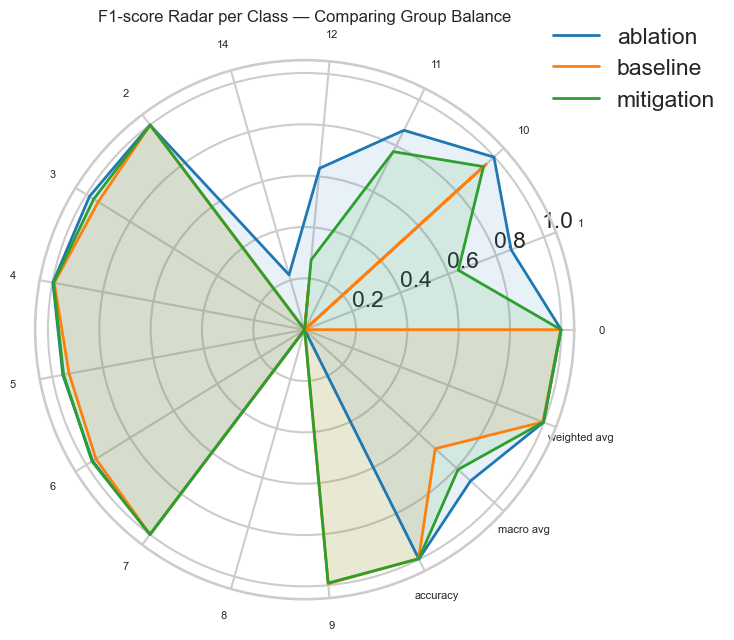

In [31]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt

# Aggregate mean F1 per group per class (using 'unnamed:_0' as class index)
radar_df = metrics_df.groupby(["group", "unnamed:_0"])["f1-score"].mean().reset_index()
radar_pivot = radar_df.pivot(index="group", columns="unnamed:_0", values="f1-score").fillna(0)

categories = [str(c) for c in radar_pivot.columns]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(7,7))
for idx, row in radar_pivot.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=idx, linewidth=2)
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories, size=8)
plt.title("F1-score Radar per Class — Comparing Group Balance", size=12)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()


🏆 Best performing scenario per class:


,type,scenario,f1-score
10,Macro avg,no_Flow,0.899053


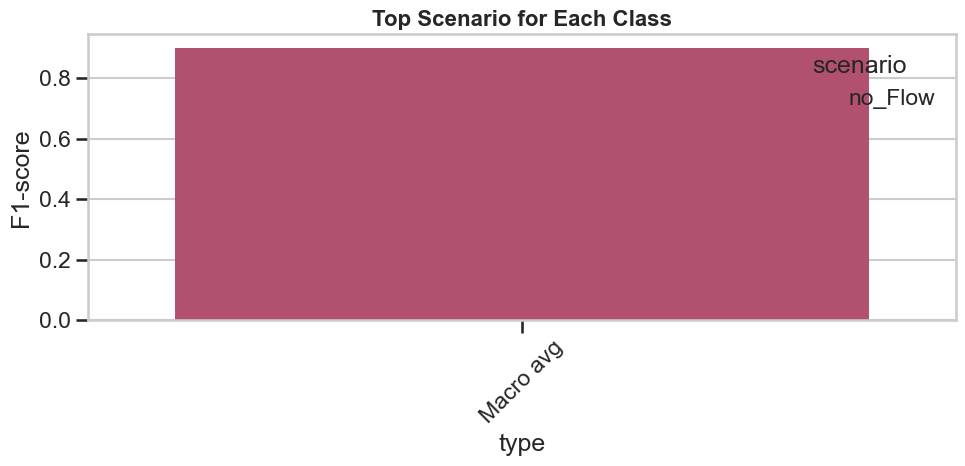

In [10]:
best_per_class = (
    combined.groupby(["type", "scenario"])["f1-score"]
    .mean()
    .reset_index()
    .sort_values("f1-score", ascending=False)
    .groupby("type")
    .head(1)
)
print("🏆 Best performing scenario per class:")
display(best_per_class)

plt.figure(figsize=(10, 5))
sns.barplot(data=best_per_class, x="type", y="f1-score", hue="scenario", palette="flare")
plt.title("Top Scenario for Each Class", fontsize=16, weight="bold")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


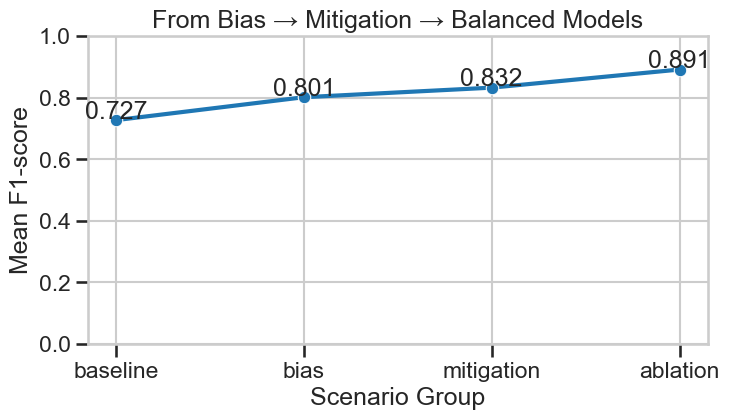

In [30]:
summary = metrics_df.groupby("group")["f1-score"].mean().reset_index()
summary["rank"] = summary["f1-score"].rank()
summary = summary.sort_values("f1-score")

plt.figure(figsize=(8,4))
sns.lineplot(data=summary, x="group", y="f1-score", marker="o", linewidth=3)
for i, row in summary.iterrows():
    plt.text(row["group"], row["f1-score"]+0.005, f"{row['f1-score']:.3f}", ha='center')
plt.title("From Bias → Mitigation → Balanced Models")
plt.ylabel("Mean F1-score")
plt.xlabel("Scenario Group")
plt.ylim(0,1)
plt.show()


In [ ]:
out_path = Path("/ids-bias-project/results/final_figures_summary.csv")
summary.to_csv(out_path, index=False)
print(f"📁 Saved summary table → {out_path}")